In [1]:
from one.api import ONE
import numpy as np

# Instantiate the ONE API
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international')

# Search for all experiments with channels.mlapdv dataset
eids = one.search(data='channels.mlapdv')

# Concatenate all the mlapdv values from the probe00 collections
mlapdv_concat = []
probe00_eids = []
for eid in eids:
    try:
        mlapdv = one.load_dataset(eid, 'channels.mlapdv.npy', collection='alf/probe00/pykilosort')
        mlapdv_mean = np.mean(mlapdv, axis=0) # compute the mean of the mlpadv values
        mlapdv_concat.append(mlapdv_mean)
        probe00_eids.append((eid, 'probe00'))
    except:
        pass

# Concatenate all the mlapdv values from the probe01 collections
probe01_eids = []
for eid in eids:
    try:
        mlapdv = one.load_dataset(eid, 'channels.mlapdv.npy', collection='alf/probe01/pykilosort')
        mlapdv_mean = np.mean(mlapdv, axis=0) # compute the mean of the mlpadv values
        mlapdv_concat.append(mlapdv_mean)
        probe01_eids.append((eid, 'probe01'))
    except:
        pass

# Concatenate all the mlapdv values together
mlapdv_concat = np.stack(mlapdv_concat) # stack the mlpadv values into a single array
eids = probe00_eids + probe01_eids # combine the eid and probe information into a single list

/home/maria/anaconda3/lib/python3.9/site-packages/one/api.py:472: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  datasets = datasets.loc[(sessions.index.values, ), :]
local md5 mismatch on dataset: cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.npy


Downloading: /home/maria/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS074/2021-11-22/001/alf/probe00/pykilosort/channels.mlapdv.5a4fa6a9-d563-4531-963d-c293637025eb.npy Bytes: 4736


100%|██████████| 0.0045166015625/0.0045166015625 [00:00<00:00,  3.39s/it]


In [2]:
np.save('mlapdv_concat.npy',mlapdv_concat)
np.save('mlapdv_eids.npy', eids)

In [4]:
mlapdv_concat.shape

(570, 3)

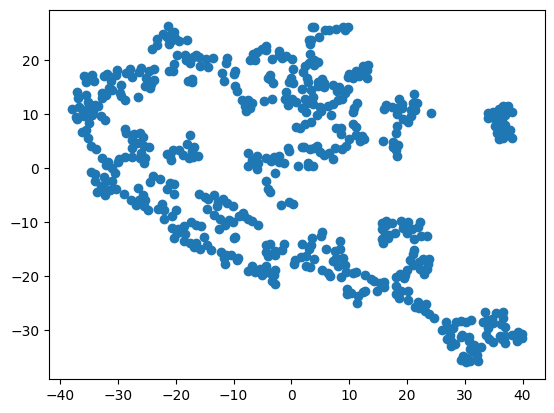

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(mlapdv_concat)
plt.scatter(X_embedded[:,0],X_embedded[:,1])

In [12]:
np.save('probe_location_embeddings.npy',X_embedded)

In [ ]:
import matplotlib.pyplot as plt
from ibllib.atlas import atlas as at
def generate_mlapdv_plots(eids):
    atlas=at.AllenAtlas()
    for i, eid in enumerate(eids):
        # Load mlapdv.npy for probe00 if it exists
        if eid[1]=='probe00':
            mlapdv = one.load_dataset(eid[0], 'channels.mlapdv.npy', collection=f'alf/probe00/pykilosort')

        # Load mlapdv.npy for probe01 if it exists
        if eid[1]=='probe01':
            mlapdv = one.load_dataset(eid[0], 'channels.mlapdv.npy', collection=f'alf/probe01/pykilosort')


        # Create the xyz array
        xyz = np.c_[mlapdv[:, 0].astype(np.float64) / 1e6, mlapdv[:, 1].astype(np.float64) / 1e6, mlapdv[:, 2].astype(np.float64) / 1e6]

        fit=at.Trajectory.fit(xyz)
        proj=fit.project(xyz)

        # Create a figure with subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 6),gridspec_kw={'wspace': 0.5})

        # Render the first image
        ax0 = atlas.plot_tilted_slice(xyz, 0, ax=axs[0])
        ax0[0].scatter(proj[:, 1]*1e6, proj[:, 2]*1e6, c='pink', s=5)

        # Render the second image
        ax1 = atlas.plot_tilted_slice(xyz, 1, ax=axs[1])
        ax1[0].scatter(proj[:, 0]*1e6, proj[:, 2]*1e6, c='pink', s=5)

        # Save the plot to a file with a unique name
        filename = f'static/mlapdv_plot_{i}.png'
        fig.savefig(filename, bbox_inches='tight')

        # Return the path to the saved file
        yield eid, filename